# Search Model

Source : 
- Ljungqvist and Sargent (2004) page 172
- Gemini (2.5 Flash) for the Python code

## The Model

The Bellman equation is given by :
$v_i = \max \left\{ \frac{w_i}{1 - \beta}, \beta \sum_{j=1}^{n} p_{ij} v_j \right\} \quad \text{for } i = 1, \dots, n$

with the following transition probability
$p_{ij} = \text{Prob}(w_{t+1} = \tilde{w}_j \mid w_t = \tilde{w}_i)$

We ue the following parameterization of the transition probability:
$$
P = \begin{pmatrix}
0.7 & 0.2 & 0.1 \\
0.2 & 0.6 & 0.2 \\
0.1 & 0.2 & 0.7
\end{pmatrix}
$$

## Algorithm: Value Function Iteration for Search Model

1.  **Define Parameters:**
    * `w`: Array of possible wage offers (states).
    * `P`: Transition probability matrix (P[i,j] = prob of moving from state i to j).
    * `beta`: Discount factor.
    * `tolerance`: Convergence threshold.
    * `max_iterations`: Maximum number of iterations.

2.  **Initialization:**
    * Initialize `v_old` (the value function from the previous iteration) with an array of zeros, or any reasonable starting guess for the value function.
    * Calculate `accept_values` for each wage state `i`: `w_i / (1 - beta)`. This represents the value of accepting the current wage offer `w_i` forever.

3.  **Iteration Loop (Value Function Iteration):**
    * **Loop** `k` from 1 to `max_iterations`:
        * Set `v_current = v_old`. (Store the current value function to check for convergence later).
        * **Calculate `reject_values`:** For each wage state `i`:
            * `expected_future_value_if_reject = sum_{j=1 to n} (P[i, j] * v_current[j])`
            * `reject_values[i] = beta * expected_future_value_if_reject`
        * **Apply Bellman Operator:** For each wage state `i`:
            * `v_new[i] = max(accept_values[i], reject_values[i])`
        * **Check for Convergence:**
            * Calculate the maximum absolute difference between `v_new` and `v_current`: `max_diff = max(abs(v_new - v_current))`.
            * If `max_diff < tolerance`, then the value function has converged. **Break** the loop.
        * **Update for Next Iteration:**
            * Set `v_old = v_new`.

4.  **Determine Optimal Policy:**
    * Once `v_new` has converged (let's call it `v_converged`), determine the optimal policy for each wage state `i`:
        * If `accept_values[i] >= (beta * sum_{j=1 to n} (P[i, j] * v_converged[j]))`, then the optimal policy for wage `w_i` is 'Accept'.
        * Else, the optimal policy for wage `w_i` is 'Reject'.

5.  **Return Results:**
    * Return the converged value function (`v_converged`), the optimal policy, and the number of iterations taken.


In [5]:
import numpy as np

def solve_search_model(w, P, beta, tolerance=1e-6, max_iterations=1000):
    """
    Solves a univariate search model using Value Function Iteration.

    The Bellman equation is:
    v_i = max{ w_i / (1 - beta), beta * sum_{j=1 to n} (p_ij * v_j) }

    Args:
        w (np.array): A 1D numpy array of possible wage offers (n states).
        P (np.array): A 2D numpy array (n x n) representing the transition
                      probability matrix, where P[i, j] is the probability
                      of transitioning from wage state i to wage state j.
                      Rows must sum to 1.
        beta (float): The discount factor (between 0 and 1).
        tolerance (float): The convergence criterion for the value function.
        max_iterations (int): Maximum number of iterations for VFI.

    Returns:
        tuple: A tuple containing:
            - v (np.array): The converged value function for each wage state.
            - policy (np.array): The optimal policy for each wage state.
                                 1 indicates 'Accept', 0 indicates 'Reject'.
            - iterations (int): The number of iterations taken to converge.
    """
    n = len(w)

    # 1. Initialize the value function (e.g., to zeros or the minimum possible value)
    # A common initialization is to accept the lowest wage, or simply zeros.
    # We can also initialize with the value of accepting the lowest wage
    # as a lower bound, or simply zeros.
    v = np.zeros(n) # Initialize with zeros for simplicity

    # Pre-calculate the value of accepting each offer
    accept_values = w / (1 - beta)

    print(f"Starting Value Function Iteration for {n} wage states...")
    print(f"Wage offers (w): {w}")
    print(f"Discount factor (beta): {beta}")
    print(f"Transition Matrix (P):\n{P}")
    print("-" * 30)

    for k in range(max_iterations):
        v_prev = v.copy()

        # Calculate the value of rejecting and continuing to search
        # This involves matrix multiplication: P @ v_prev
        reject_values = beta * (P @ v_prev)

        # Apply the Bellman operator: take the maximum of accepting or rejecting
        v = np.maximum(accept_values, reject_values)

        # Check for convergence
        if np.max(np.abs(v - v_prev)) < tolerance:
            print(f"Converged in {k + 1} iterations.")
            break
    else:
        print(f"Did not converge after {max_iterations} iterations. Consider increasing max_iterations or tolerance.")

    # Determine the optimal policy based on the converged value function
    policy = (accept_values >= reject_values).astype(int) # 1 for Accept, 0 for Reject

    return v, policy, k + 1

# --- Benchmark Parameterization ---
# 1. Number of wage states (n)
n_states = 3

# 2. Possible wage offers (w)
# Let's define three distinct wage levels: low, medium, high
benchmark_w = np.array([10.0, 20.0, 30.0])

# 3. Discount factor (beta)
# A typical value for beta in economic models, implying patience.
benchmark_beta = 0.95

# 4. Transition Probability Matrix (P)
# P[i, j] = probability of receiving wage offer w_j in the next period,
# given you are currently considering (or just rejected) wage w_i.
# Each row must sum to 1.

# Let's create a simple, intuitive transition matrix:
# - From a low wage (w[0]): Higher chance of staying low, some chance of medium, small chance of high.
# - From a medium wage (w[1]): Balanced chances, slightly more likely to stay medium.
# - From a high wage (w[2]): Higher chance of staying high, some chance of medium, small chance of low.
benchmark_P = np.array([
    [0.7, 0.2, 0.1],  # From w[0] (low): 70% chance of new low, 20% medium, 10% high
    [0.2, 0.6, 0.2],  # From w[1] (medium): 20% low, 60% medium, 20% high
    [0.1, 0.2, 0.7]   # From w[2] (high): 10% low, 20% medium, 70% high
])

# Ensure rows sum to 1 (for verification)
assert np.allclose(benchmark_P.sum(axis=1), 1), "Rows of P must sum to 1."

# --- Solve the model with benchmark parameters ---
converged_v, optimal_policy, num_iterations = solve_search_model(
    benchmark_w, benchmark_P, benchmark_beta
)

# --- Display Results ---
print("\n" + "="*40)
print("           MODEL SOLUTION RESULTS")
print("="*40)
print(f"Converged Value Function (v):")
for i, val in enumerate(converged_v):
    print(f"  v_{i+1} (for wage {benchmark_w[i]}): {val:.4f}")

print("\nOptimal Policy:")
for i, decision in enumerate(optimal_policy):
    wage = benchmark_w[i]
    if decision == 1:
        print(f"  For wage {wage}: ACCEPT (Value: {wage / (1 - benchmark_beta):.4f})")
    else:
        # Calculate expected future value if rejected for comparison
        expected_future_value = benchmark_beta * np.sum(benchmark_P[i, :] * converged_v)
        print(f"  For wage {wage}: REJECT (Expected Future Value: {expected_future_value:.4f})")

print(f"\nTotal iterations: {num_iterations}")

# --- Interpretation of Policy (Example) ---
# In a typical search model, there's a reservation wage. Any offer above this
# wage is accepted, and any below is rejected. Let's see if our policy
# reflects this.
# If the policy is [0, 1, 1], it means the lowest wage is rejected, and the
# medium and high wages are accepted, indicating a reservation wage between
# the low and medium wage.


Starting Value Function Iteration for 3 wage states...
Wage offers (w): [10. 20. 30.]
Discount factor (beta): 0.95
Transition Matrix (P):
[[0.7 0.2 0.1]
 [0.2 0.6 0.2]
 [0.1 0.2 0.7]]
------------------------------
Converged in 86 iterations.

           MODEL SOLUTION RESULTS
Converged Value Function (v):
  v_1 (for wage 10.0): 427.6980
  v_2 (for wage 20.0): 454.0991
  v_3 (for wage 30.0): 600.0000

Optimal Policy:
  For wage 10.0: REJECT (Expected Future Value: 427.6980)
  For wage 20.0: REJECT (Expected Future Value: 454.0991)
  For wage 30.0: ACCEPT (Value: 600.0000)

Total iterations: 86


Starting Value Function Iteration for 3 wage states...
Wage offers (w): [10. 20. 30.]
Discount factor (beta): 0.95
Transition Matrix (P):
[[0.7 0.2 0.1]
 [0.2 0.6 0.2]
 [0.1 0.2 0.7]]
------------------------------
Converged in 86 iterations.

           MODEL SOLUTION RESULTS
Converged Value Function (v):
  v_1 (for wage 10.0): 427.6980
  v_2 (for wage 20.0): 454.0991
  v_3 (for wage 30.0): 600.0000

Optimal Policy:
  For wage 10.0: REJECT (Expected Future Value: 427.6980)
  For wage 20.0: REJECT (Expected Future Value: 454.0991)
  For wage 30.0: ACCEPT (Value: 600.0000)

Total iterations: 86


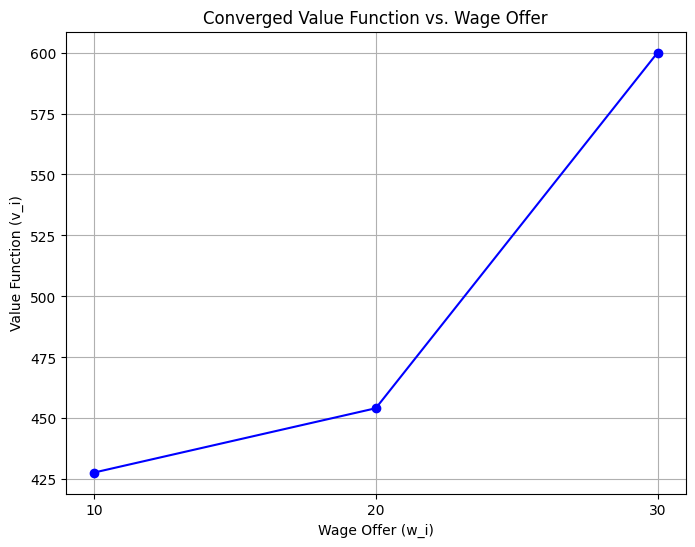

In [6]:
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib for plotting

def solve_search_model(w, P, beta, tolerance=1e-6, max_iterations=1000):
    """
    Solves a univariate search model using Value Function Iteration.

    The Bellman equation is:
    v_i = max{ w_i / (1 - beta), beta * sum_{j=1 to n} (p_ij * v_j) }

    Args:
        w (np.array): A 1D numpy array of possible wage offers (n states).
        P (np.array): A 2D numpy array (n x n) representing the transition
                      probability matrix, where P[i, j] is the probability
                      of transitioning from wage state i to wage state j.
                      Rows must sum to 1.
        beta (float): The discount factor (between 0 and 1).
        tolerance (float): The convergence criterion for the value function.
        max_iterations (int): Maximum number of iterations for VFI.

    Returns:
        tuple: A tuple containing:
            - v (np.array): The converged value function for each wage state.
            - policy (np.array): The optimal policy for each wage state.
                                 1 indicates 'Accept', 0 indicates 'Reject'.
            - iterations (int): The number of iterations taken to converge.
    """
    n = len(w)

    # 1. Initialize the value function (e.g., to zeros or the minimum possible value)
    # A common initialization is to accept the lowest wage, or simply zeros.
    # We can also initialize with the value of accepting the lowest wage
    # as a lower bound, or simply zeros.
    v = np.zeros(n) # Initialize with zeros for simplicity

    # Pre-calculate the value of accepting each offer
    accept_values = w / (1 - beta)

    print(f"Starting Value Function Iteration for {n} wage states...")
    print(f"Wage offers (w): {w}")
    print(f"Discount factor (beta): {beta}")
    print(f"Transition Matrix (P):\n{P}")
    print("-" * 30)

    for k in range(max_iterations):
        v_prev = v.copy()

        # Calculate the value of rejecting and continuing to search
        # This involves matrix multiplication: P @ v_prev
        reject_values = beta * (P @ v_prev)

        # Apply the Bellman operator: take the maximum of accepting or rejecting
        v = np.maximum(accept_values, reject_values)

        # Check for convergence
        if np.max(np.abs(v - v_prev)) < tolerance:
            print(f"Converged in {k + 1} iterations.")
            break
    else:
        print(f"Did not converge after {max_iterations} iterations. Consider increasing max_iterations or tolerance.")

    # Determine the optimal policy based on the converged value function
    policy = (accept_values >= reject_values).astype(int) # 1 for Accept, 0 for Reject

    return v, policy, k + 1

# --- Benchmark Parameterization ---
# 1. Number of wage states (n)
n_states = 3

# 2. Possible wage offers (w)
# Let's define three distinct wage levels: low, medium, high
benchmark_w = np.array([10.0, 20.0, 30.0])

# 3. Discount factor (beta)
# A typical value for beta in economic models, implying patience.
benchmark_beta = 0.95

# 4. Transition Probability Matrix (P)
# P[i, j] = probability of receiving wage offer w_j in the next period,
# given you are currently considering (or just rejected) wage w_i.
# Each row must sum to 1.

# Let's create a simple, intuitive transition matrix:
# - From a low wage (w[0]): Higher chance of staying low, some chance of medium, small chance of high.
# - From a medium wage (w[1]): Balanced chances, slightly more likely to stay medium.
# - From a high wage (w[2]): Higher chance of staying high, some chance of medium, small chance of low.
benchmark_P = np.array([
    [0.7, 0.2, 0.1],  # From w[0] (low): 70% chance of new low, 20% medium, 10% high
    [0.2, 0.6, 0.2],  # From w[1] (medium): 20% low, 60% medium, 20% high
    [0.1, 0.2, 0.7]   # From w[2] (high): 10% low, 20% medium, 70% high
])

# Ensure rows sum to 1 (for verification)
assert np.allclose(benchmark_P.sum(axis=1), 1), "Rows of P must sum to 1."

# --- Solve the model with benchmark parameters ---
converged_v, optimal_policy, num_iterations = solve_search_model(
    benchmark_w, benchmark_P, benchmark_beta
)

# --- Display Results ---
print("\n" + "="*40)
print("           MODEL SOLUTION RESULTS")
print("="*40)
print(f"Converged Value Function (v):")
for i, val in enumerate(converged_v):
    print(f"  v_{i+1} (for wage {benchmark_w[i]}): {val:.4f}")

print("\nOptimal Policy:")
for i, decision in enumerate(optimal_policy):
    wage = benchmark_w[i]
    if decision == 1:
        print(f"  For wage {wage}: ACCEPT (Value: {wage / (1 - benchmark_beta):.4f})")
    else:
        # Calculate expected future value if rejected for comparison
        expected_future_value = benchmark_beta * np.sum(benchmark_P[i, :] * converged_v)
        print(f"  For wage {wage}: REJECT (Expected Future Value: {expected_future_value:.4f})")

print(f"\nTotal iterations: {num_iterations}")

# --- Interpretation of Policy (Example) ---
# In a typical search model, there's a reservation wage. Any offer above this
# wage is accepted, and any below is rejected. Let's see if our policy
# reflects this.
# If the policy is [0, 1, 1], it means the lowest wage is rejected, and the
# medium and high wages are accepted, indicating a reservation wage between
# the low and medium wage.

# --- Plotting the Value Function ---
plt.figure(figsize=(8, 6))
plt.plot(benchmark_w, converged_v, marker='o', linestyle='-', color='blue')
plt.title('Converged Value Function vs. Wage Offer')
plt.xlabel('Wage Offer (w_i)')
plt.ylabel('Value Function (v_i)')
plt.grid(True)
plt.xticks(benchmark_w) # Set x-ticks to the specific wage values
plt.show()


Starting Value Function Iteration for 50 wage states...
Wage offers (w): [10.         14.08163265 18.16326531 22.24489796 26.32653061] ... (showing some values for brevity)
Discount factor (beta): 0.95
Transition Matrix (P) shape: (50, 50)
------------------------------
Converged in 37 iterations.

           MODEL SOLUTION RESULTS
Converged Value Function (v) for 50 states (showing first/last 5):
  v_1 (for wage 10.00): 232.7619
  v_2 (for wage 10.41): 234.6427
  v_3 (for wage 10.82): 236.8688
  v_4 (for wage 11.22): 239.4899
  v_5 (for wage 11.63): 242.5537
  ...
  v_46 (for wage 28.37): 567.3469
  v_47 (for wage 28.78): 575.5102
  v_48 (for wage 29.18): 583.6735
  v_49 (for wage 29.59): 591.8367
  v_50 (for wage 30.00): 600.0000

Optimal Policy (showing first/last 5 decisions):
  For wage 10.00: REJECT (Expected Future Value: 232.7619)
  For wage 10.41: REJECT (Expected Future Value: 234.6427)
  For wage 10.82: REJECT (Expected Future Value: 236.8688)
  For wage 11.22: REJECT (Expec

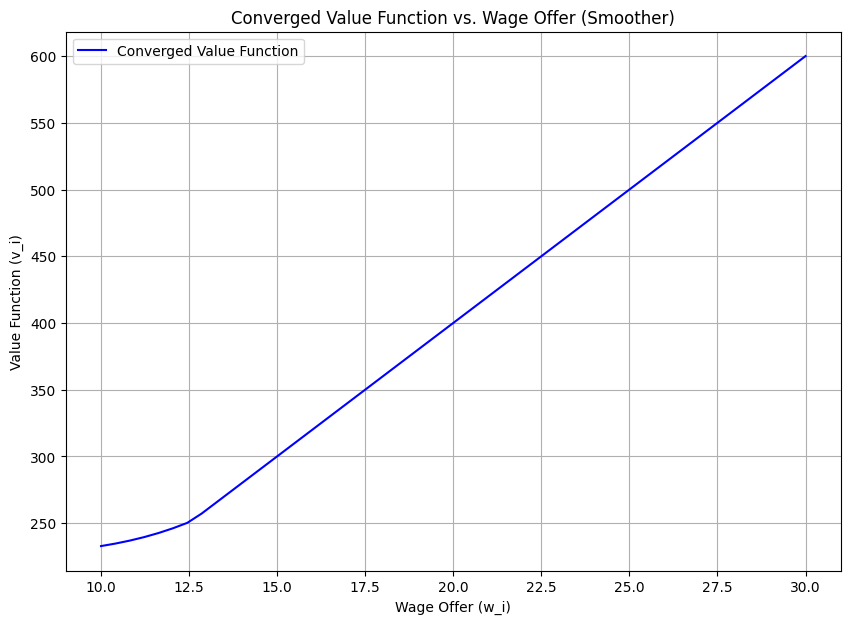

In [10]:
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib for plotting

def solve_search_model(w, P, beta, tolerance=1e-6, max_iterations=1000):
    """
    Solves a univariate search model using Value Function Iteration.

    The Bellman equation is:
    v_i = max{ w_i / (1 - beta), beta * sum_{j=1 to n} (p_ij * v_j) }

    Args:
        w (np.array): A 1D numpy array of possible wage offers (n states).
        P (np.array): A 2D numpy array (n x n) representing the transition
                      probability matrix, where P[i, j] is the probability
                      of transitioning from wage state i to wage state j.
                      Rows must sum to 1.
        beta (float): The discount factor (between 0 and 1).
        tolerance (float): The convergence criterion for the value function.
        max_iterations (int): Maximum number of iterations for VFI.

    Returns:
        tuple: A tuple containing:
            - v (np.array): The converged value function for each wage state.
            - policy (np.array): The optimal policy for each wage state.
                                 1 indicates 'Accept', 0 indicates 'Reject'.
            - iterations (int): The number of iterations taken to converge.
    """
    n = len(w)

    # 1. Initialize the value function (e.g., to zeros or the minimum possible value)
    # A common initialization is to accept the lowest wage, or simply zeros.
    # We can also initialize with the value of accepting the lowest wage
    # as a lower bound, or simply zeros.
    v = np.zeros(n) # Initialize with zeros for simplicity

    # Pre-calculate the value of accepting each offer
    accept_values = w / (1 - beta)

    print(f"Starting Value Function Iteration for {n} wage states...")
    print(f"Wage offers (w): {w[::(n//5) if n > 5 else 1]} ... (showing some values for brevity)") # Print fewer values if n is large
    print(f"Discount factor (beta): {beta}")
    print(f"Transition Matrix (P) shape: {P.shape}")
    print("-" * 30)

    for k in range(max_iterations):
        v_prev = v.copy()

        # Calculate the value of rejecting and continuing to search
        # This involves matrix multiplication: P @ v_prev
        reject_values = beta * (P @ v_prev)

        # Apply the Bellman operator: take the maximum of accepting or rejecting
        v = np.maximum(accept_values, reject_values)

        # Check for convergence
        if np.max(np.abs(v - v_prev)) < tolerance:
            print(f"Converged in {k + 1} iterations.")
            break
    else:
        print(f"Did not converge after {max_iterations} iterations. Consider increasing max_iterations or tolerance.")

    # Determine the optimal policy based on the converged value function
    policy = (accept_values >= reject_values).astype(int) # 1 for Accept, 0 for Reject

    return v, policy, k + 1

# --- Benchmark Parameterization ---
# 1. Number of wage states (n) - Increased for a smoother value function
n_states = 50 # Increased from 3 to 50 for a smoother representation

# 2. Possible wage offers (w) - Linearly spaced between a min and max wage
benchmark_w = np.linspace(10.0, 30.0, n_states)

# 3. Discount factor (beta)
benchmark_beta = 0.95

# 4. Transition Probability Matrix (P)
# For a larger number of states, we'll create a transition matrix
# where probabilities are higher for staying in the current state or moving
# to nearby states, and decay for states further away.
benchmark_P = np.zeros((n_states, n_states))
for i in range(n_states):
    for j in range(n_states):
        # Using a Gaussian-like decay based on distance between states
        # The 'scale' factor controls the spread of probabilities around the current state
        distance = abs(i - j)
        scale = n_states / 10 # Adjust this value to control how 'sticky' states are
        benchmark_P[i, j] = np.exp(-0.5 * (distance / scale)**2)

    # Normalize each row to sum to 1
    benchmark_P[i, :] /= np.sum(benchmark_P[i, :])

# Ensure rows sum to 1 (for verification)
assert np.allclose(benchmark_P.sum(axis=1), 1), "Rows of P must sum to 1."

# --- Solve the model with benchmark parameters ---
converged_v, optimal_policy, num_iterations = solve_search_model(
    benchmark_w, benchmark_P, benchmark_beta
)

# --- Display Results ---
print("\n" + "="*40)
print("           MODEL SOLUTION RESULTS")
print("="*40)
print(f"Converged Value Function (v) for {n_states} states (showing first/last 5):")
for i, val in enumerate(converged_v):
    if i < 5 or i >= n_states - 5: # Print only first and last 5 for large n
        print(f"  v_{i+1} (for wage {benchmark_w[i]:.2f}): {val:.4f}")
    elif i == 5:
        print("  ...")


print("\nOptimal Policy (showing first/last 5 decisions):")
for i, decision in enumerate(optimal_policy):
    wage = benchmark_w[i]
    if i < 5 or i >= n_states - 5: # Print only first and last 5 for large n
        if decision == 1:
            print(f"  For wage {wage:.2f}: ACCEPT (Value: {wage / (1 - benchmark_beta):.4f})")
        else:
            # Calculate expected future value if rejected for comparison
            expected_future_value = benchmark_beta * np.sum(benchmark_P[i, :] * converged_v)
            print(f"  For wage {wage:.2f}: REJECT (Expected Future Value: {expected_future_value:.4f})")
    elif i == 5:
        print("  ...")


print(f"\nTotal iterations: {num_iterations}")

# --- Interpretation of Policy (Example) ---
# In a typical search model, there's a reservation wage. Any offer above this
# wage is accepted, and any below is rejected. Let's see if our policy
# reflects this.
# If the policy is [0, 1, 1], it means the lowest wage is rejected, and the
# medium and high wages are accepted, indicating a reservation wage between
# the low and medium wage.

# --- Plotting the Value Function ---
plt.figure(figsize=(10, 7))
plt.plot(benchmark_w, converged_v, marker='', linestyle='-', color='blue', label='Converged Value Function')
plt.title('Converged Value Function vs. Wage Offer (Smoother)')
plt.xlabel('Wage Offer (w_i)')
plt.ylabel('Value Function (v_i)')
plt.grid(True)
plt.legend()
plt.show()
